# Dependencies

In [1]:
!pip install BlackBoxAuditing

In [2]:
pip install 'aif360[inFairness]'

In [3]:
!pip install fairlearn aif360 shap lime numpy pandas scikit-learn matplotlib seaborn

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import shap
import lime.lime_tabular
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# Dataset and preprocessing

In [5]:
df = pd.read_csv("/content/adult_merged_with_headers.csv");

In [6]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#This is not processed so we first pre process it


In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("adult_merged_with_headers.csv")

# Handle missing values
df = df.dropna()

# Encode categorical features
label_encoders = {}
for col in ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalize continuous features
scaler = StandardScaler()
df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']])

# Define sensitive attribute for bias detection
sensitive_attr = "sex"  # You can also check for 'race'

# Split dataset
X = df.drop("income", axis=1)
y = df["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save processed dataset
df.to_csv("adult_preprocessed.csv", index=False)


In [8]:
df = pd.read_csv("adult_preprocessed.csv")

In [9]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.025996,7,-1.061979,9,1.136512,4,1,1,4,1,0.146932,-0.217127,-0.034087,39,0
1,0.828308,6,-1.007104,9,1.136512,2,4,0,4,1,-0.144804,-0.217127,-2.213032,39,0
2,-0.046942,4,0.246034,11,-0.419335,0,6,1,4,1,-0.144804,-0.217127,-0.034087,39,0
3,1.047121,4,0.426663,1,-1.197259,2,6,0,2,1,-0.144804,-0.217127,-0.034087,39,0
4,-0.776316,4,1.408530,9,1.136512,2,10,5,2,0,-0.144804,-0.217127,-0.034087,5,0


In [10]:
# Define target and let user choose protected attributes
target_col = 'income'
protected_cols = [col for col in df.columns if col != target_col]
print(f"Available Protected Attributes: {protected_cols}")

Available Protected Attributes: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [11]:
print("Select protected attributes (comma-separated, e.g., 'sex,race'):")
selected_protected_cols = input().split(',')
selected_protected_cols = [col.strip() for col in selected_protected_cols if col.strip() in df.columns]

Select protected attributes (comma-separated, e.g., 'sex,race'):
sex


In [12]:
X = df.drop(columns=[target_col])
y = df[target_col]
y = (y == y.max()).astype(int)

# Apply Bias Mitigation before model training


In [14]:
bias_reduction_results = []
for protected_col in selected_protected_cols:
    dataset_orig = StandardDataset(df, label_name=target_col, favorable_classes=[1], protected_attribute_names=[protected_col], privileged_classes=[[1]])

    # Reweighing and Disparate Impact Remover
    reweighing = Reweighing(privileged_groups=[{protected_col: 1}], unprivileged_groups=[{protected_col: 0}])
    dataset_transf = reweighing.fit_transform(dataset_orig)

    di_remover = DisparateImpactRemover(repair_level=1.0)
    dataset_transf = di_remover.fit_transform(dataset_transf)

    # Adversarial Debiasing
    tf.compat.v1.reset_default_graph()
    sess = tf.compat.v1.Session()
    adv_debias = AdversarialDebiasing(privileged_groups=[{protected_col: 1}],
                                  unprivileged_groups=[{protected_col: 0}],
                                  scope_name='adv_debiasing',
                                  num_epochs=10,
                                  sess=sess)
    dataset_transf = adv_debias.fit_predict(dataset_transf)
    sess.close()  # Properly close session after usage

    # Prejudice Remover
    pr_model = PrejudiceRemover(sensitive_attr=protected_col, eta=1.0)
    pr_model.fit(dataset_transf)
    pred_dataset = pr_model.predict(dataset_transf)
    dataset_transf.labels = pred_dataset.labels  # Update only labels




    # Reject Option Classification
    reject_option = RejectOptionClassification(
        privileged_groups=[{protected_col: 1}],
        unprivileged_groups=[{protected_col: 0}],
        low_class_thresh=0.4,  # Increased threshold slightly
        high_class_thresh=0.6,
        num_class_thresh=50  # More fine-grained thresholds
    )

    dataset_transf = reject_option.fit_predict(dataset_transf, dataset_transf)

    X_train_transf, X_test_transf, y_train_transf, y_test_transf = train_test_split(dataset_transf.features, dataset_transf.labels.ravel(), test_size=0.2, random_state=42)

    # Train and compare models
    clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    clf_rf.fit(X_train_transf, y_train_transf)
    clf_xgb.fit(X_train_transf, y_train_transf)

    y_pred_rf = clf_rf.predict(X_test_transf)
    y_pred_xgb = clf_xgb.predict(X_test_transf)

    X_test_transf_df = pd.DataFrame(X_test_transf, columns=X.columns)  # Convert back to DataFrame
    dp_diff_rf = demographic_parity_difference(y_test_transf, y_pred_rf, sensitive_features=X_test_transf_df[protected_col])

    # X_test_transf_df = pd.DataFrame(X_test_transf, columns=X.columns)  # Convert to DataFrame
    eq_odds_diff_rf = equalized_odds_difference(y_test_transf, y_pred_rf, sensitive_features=X_test_transf_df[protected_col])


    bias_reduction_results.append([protected_col, "RandomForest", dp_diff_rf, eq_odds_diff_rf])

    # X_test_transf_df = pd.DataFrame(X_test_transf, columns=X.columns)  # Convert NumPy array to DataFrame
    dp_diff_xgb = demographic_parity_difference(y_test_transf, y_pred_xgb, sensitive_features=X_test_transf_df[protected_col])
    eq_odds_diff_xgb = equalized_odds_difference(y_test_transf, y_pred_xgb, sensitive_features=X_test_transf_df[protected_col])


    bias_reduction_results.append([protected_col, "XGBoost", dp_diff_xgb, eq_odds_diff_xgb])

    print(f"Protected Attribute: {protected_col}")
    print(f"RandomForest - DP: {dp_diff_rf:.4f}, EO: {eq_odds_diff_rf:.4f}")
    print(f"XGBoost - DP: {dp_diff_xgb:.4f}, EO: {eq_odds_diff_xgb:.4f}")

epoch 0; iter: 0; batch classifier loss: 0.959485; batch adversarial loss: 0.869349
epoch 0; iter: 200; batch classifier loss: 0.949530; batch adversarial loss: 0.843804
epoch 1; iter: 0; batch classifier loss: 0.749682; batch adversarial loss: 0.686280
epoch 1; iter: 200; batch classifier loss: 0.603724; batch adversarial loss: 0.661029
epoch 2; iter: 0; batch classifier loss: 0.538815; batch adversarial loss: 0.670486
epoch 2; iter: 200; batch classifier loss: 0.570952; batch adversarial loss: 0.634968
epoch 3; iter: 0; batch classifier loss: 0.592880; batch adversarial loss: 0.633796
epoch 3; iter: 200; batch classifier loss: 0.544930; batch adversarial loss: 0.636688
epoch 4; iter: 0; batch classifier loss: 0.510034; batch adversarial loss: 0.614484
epoch 4; iter: 200; batch classifier loss: 0.468866; batch adversarial loss: 0.655291
epoch 5; iter: 0; batch classifier loss: 0.515989; batch adversarial loss: 0.610819
epoch 5; iter: 200; batch classifier loss: 0.536819; batch adversa

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:20:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Protected Attribute: sex
RandomForest - DP: 0.0029, EO: 0.2107
XGBoost - DP: 0.0036, EO: 0.1230


In [25]:
bias_reduction_df = pd.DataFrame(bias_reduction_results, columns=['Protected Attribute', 'Model', 'DP', 'EO'])
print("Bias Reduction Results:")
print(bias_reduction_df)


Bias Reduction Results:
  Protected Attribute         Model        DP        EO
0                 sex  RandomForest  0.002890  0.210656
1                 sex       XGBoost  0.003632  0.122951


### SHAP Implementations

A SHAP dependence plot helps us understand how a specific feature influences the model's predictions and whether it has any interactions with other features.

In [28]:
print("\nGenerating SHAP Explanations...")

# Extract feature names from the original dataset (before transformation)
feature_names = X_train.columns.tolist()

# Convert transformed test data to DataFrame with correct feature names
X_test_transf_df = pd.DataFrame(X_test_transf, columns=feature_names)

# Compute SHAP Values
explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(X_test_transf_df[:100])  # Limit for performance




Generating SHAP Explanations...


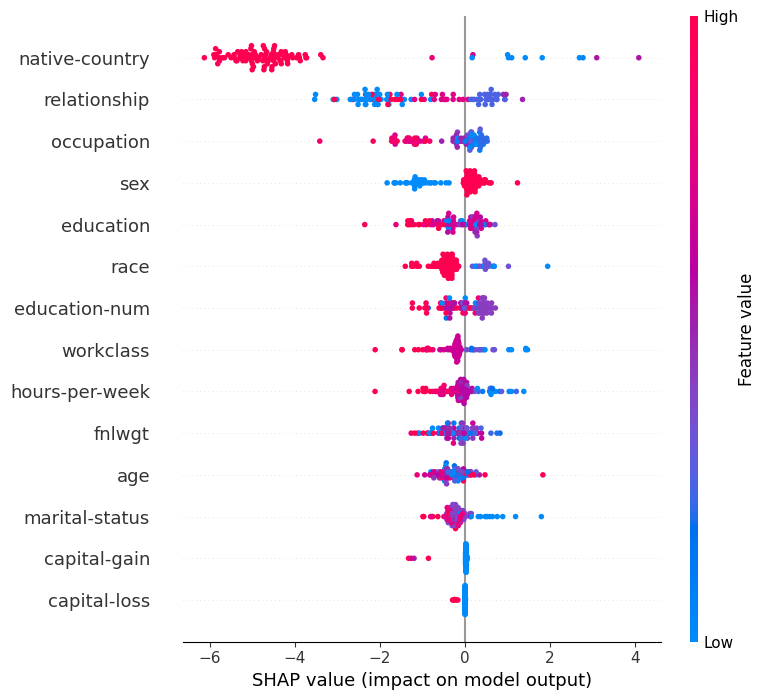

In [29]:
# 📌 2️⃣ SHAP Summary Plot
shap.summary_plot(shap_values, X_test_transf_df[:100])
plt.show()

<Figure size 2500x1500 with 0 Axes>

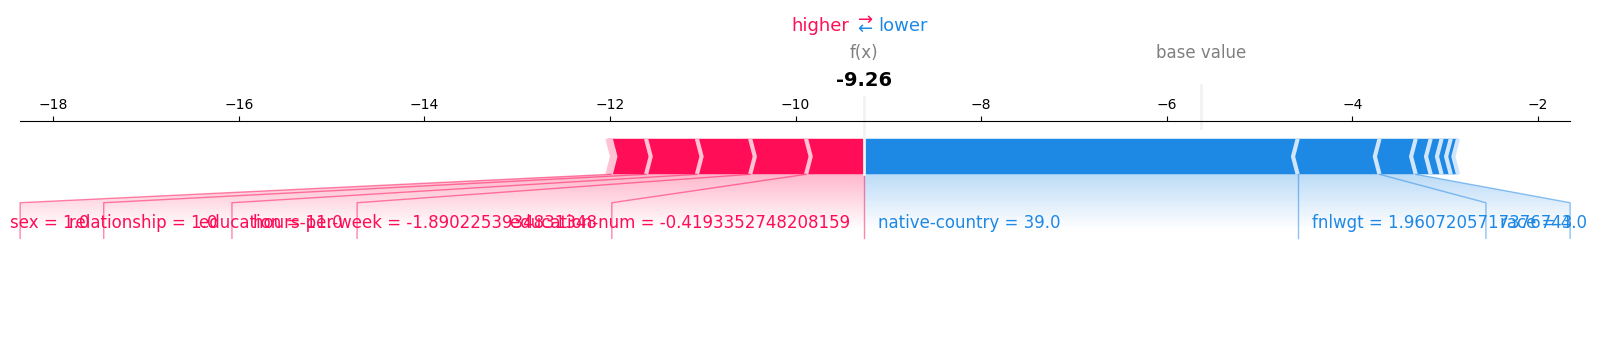

In [30]:
# 📌 3️⃣ SHAP Force Plot (First Prediction)
shap.initjs()
plt.figure(figsize=(25, 15))
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test_transf_df.iloc[0, :], matplotlib=True)
plt.show()

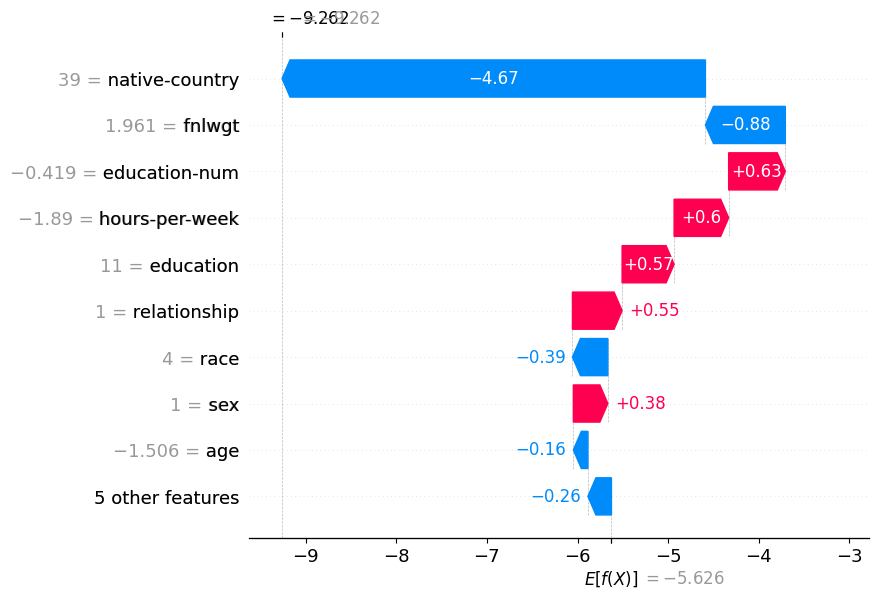

In [31]:
# 📌 4️⃣ SHAP Waterfall Plot (Explaining First Prediction)
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                     base_values=explainer.expected_value,
                                     data=X_test_transf_df.iloc[0, :]))


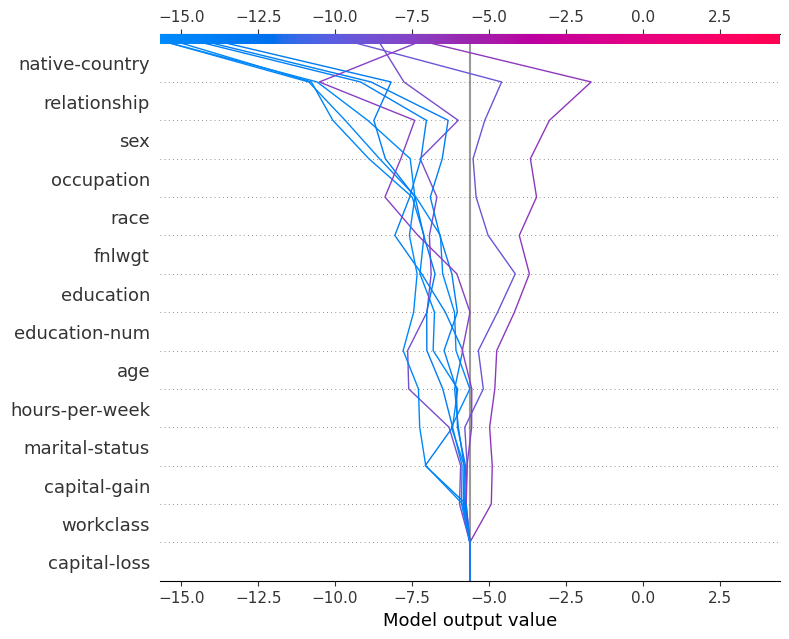

In [32]:
# 📌 5️⃣ SHAP Decision Plot
shap.decision_plot(explainer.expected_value, shap_values[:10], X_test_transf_df.iloc[:10])


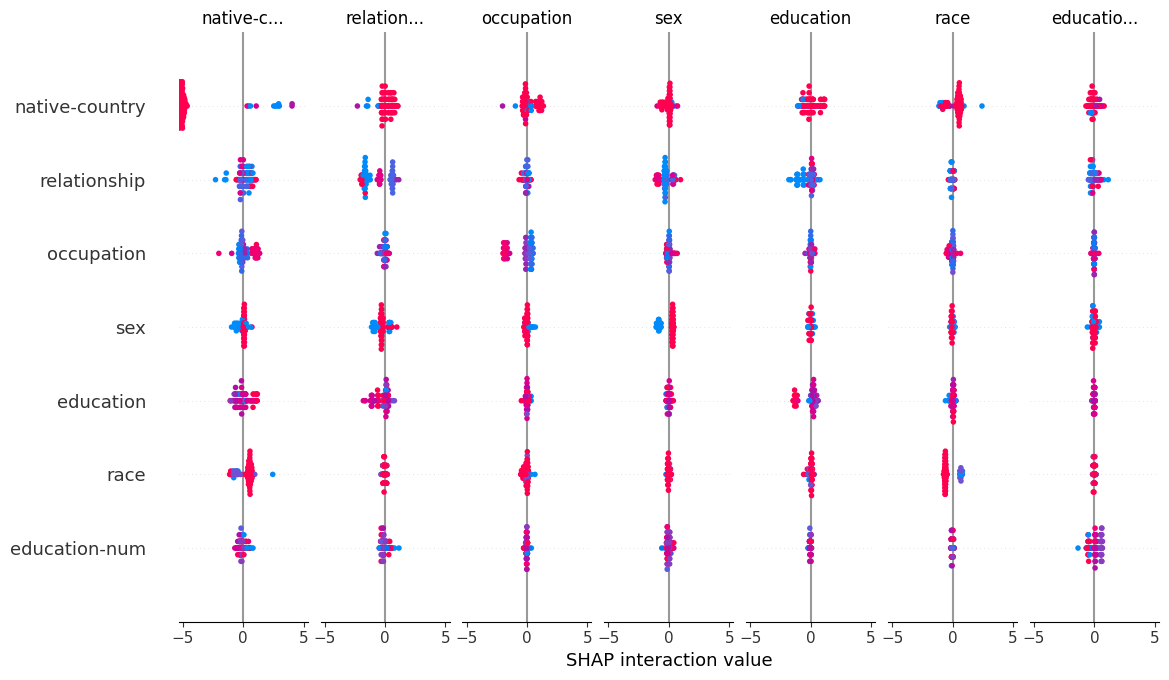

In [33]:
# 📌 6️⃣ SHAP Interaction Values (Advanced)
shap_interaction_values = explainer.shap_interaction_values(X_test_transf_df[:100])
shap.summary_plot(shap_interaction_values, X_test_transf_df[:100])


User entered checking


Available Features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Enter feature name for SHAP dependence plot: sex


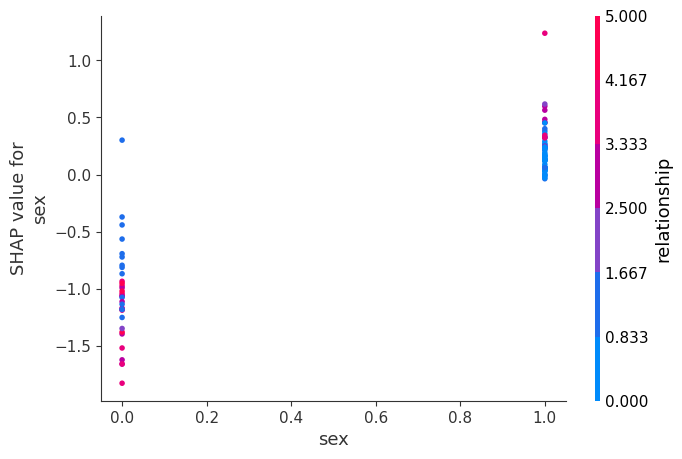

In [34]:
# Convert SHAP values to NumPy array
shap_values_array = np.array(shap_values)

# Handle case where SHAP values are returned as a list (multi-class models)
if isinstance(shap_values, list):
    shap_values_array = shap_values[0]  # Use first class (modify if needed)

# Check if user input feature is valid
print(f"Available Features: {list(X_test_transf_df.columns)}")
selected_feature = input("Enter feature name for SHAP dependence plot: ").strip()

if selected_feature in X_test_transf_df.columns:
    # Ensure SHAP values match X_test_transf_df
    num_samples, num_features = shap_values_array.shape

    if num_samples < X_test_transf_df.shape[0]:  # Trim test data if needed
        X_test_transf_df = X_test_transf_df.iloc[:num_samples, :]

    # Plot Dependence
    shap.dependence_plot(selected_feature, shap_values_array, X_test_transf_df)
else:
    print(f"❌ Invalid feature name: {selected_feature}")



LIME

In [35]:
print("\nGenerating LIME Explanations...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_transf, feature_names=X.columns, class_names=['<=50K', '>50K'], discretize_continuous=True)
exp = lime_explainer.explain_instance(X_test_transf[0], clf_xgb.predict_proba, num_features=5)
exp.show_in_notebook()

print("\nBias Analysis & Explainability Completed!")



Generating LIME Explanations...



Bias Analysis & Explainability Completed!
